In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
from scipy.optimize import curve_fit
import B00_codes.dataReader as dr

NO_MS_EQUALS_1 = 0
Q_FINAL = 1
THREE_PI_HALF_FINAL = 2
REF_MINUS_SIG  =3

In [26]:
# Saturation rate
days = np.linspace(22,22,1)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-05-' + str(int(day)) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'counter' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/time_s_set.dat'
                x_s, sig = dr.readDataNoRef(datafile)
                sig = np.array(sig[0:-1])
                n = len(x_s)
                print("n = " + str(n) + "; Avg count rate = " + str(np.round(np.average(sig))))

n = 1195; Avg count rate = 63307.0
n = 1202; Avg count rate = 61128.0
n = 2474; Avg count rate = 52445.0
n = 60; Avg count rate = 44933.0


Text(0.5, 1.0, '2023-05-22/#063_Live_counter_19-04-12 - raw')

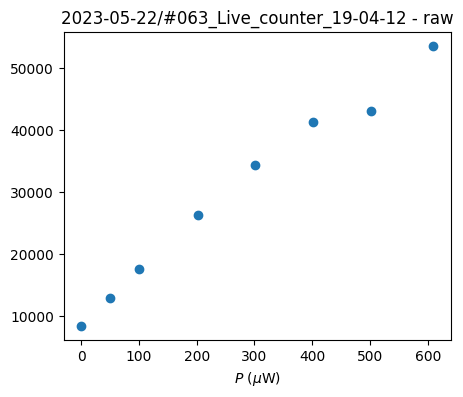

In [27]:
fig, ax = plt.subplots(figsize=(5,4))
x = np.array((610,402,301,203,100,50.4,0,502))
y = np.array((53516,41233,34321,26208,17437,12825,8367,43057))
plot = ax.plot(x,y, 'o')
ax.set_xlabel(r"$P$ ($\mu$W)")
ax.set_xlabel(r"$P$ ($\mu$W)")
ax.set_title(datafile.split('/')[4] + "/" + datafile.split('/')[5] + " - raw")

[ 168.29384218 2426.86659515]


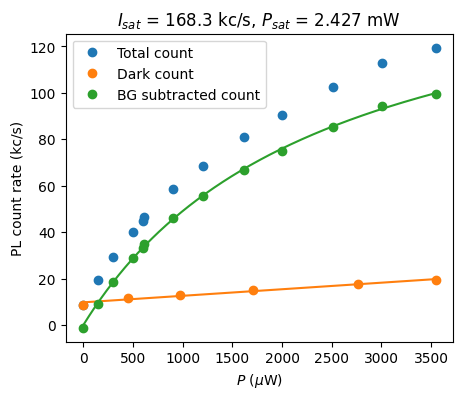

In [33]:
r = 700e-9/2/2.6
r = 150e-9 
area = np.pi*r**2

fig, ax = plt.subplots(figsize=(5,4))

x = np.array((605, 903, 1205, 1618,2000,2515,3005,3545,503,612,304,145,0))
y = np.array((46466, 58699, 68711, 81059, 90405,102411,112697,119456,40199,44883,29400,19408,8688))

xd = np.array((3545,1710,977,0, 454,2760))
yd = np.array((19258,15249,13157,8688,11496,17651))

x = np.sort(x); y = np.sort(y/1000); xd = np.sort(xd); yd = np.sort(yd/1000)
popt, pcov = curve_fit(dr.linear, xd, yd)
perr = np.sqrt(np.diag(pcov))
xdfit = np.linspace(xd[0], xd[-1], 1001)
ydfit = dr.linear(xdfit, *popt)

yfit_few = dr.linear(x,*popt)
y_subtr = y-yfit_few

xfit, yfit, popt, perr = dr.fitSaturation(x, y_subtr, guess=None)

plot1 = ax.plot(x,y,'o',color='C0', label="Total count")
plot2 = ax.plot(xd,yd, 'o', color='C1', label="Dark count")
plot3 = ax.plot(xdfit, ydfit,color='C1')
plot4 = ax.plot(x,y_subtr, 'o', color='C2', label="BG subtracted count")
plot5 = ax.plot(xfit, yfit, color='C2')
ax.set_xlabel(r"$P$ ($\mu$W)")
ax.set_ylabel(r"PL count rate (kc/s)")
ax.set_title("$I_{sat}$ = %.1f kc/s, $P_{sat}$ = %.3f mW" % (popt[0], popt[1]/1e3))
ax.legend()

print(popt)

In [ ]:
r = 700e-9/2/2.6
r = 100e-9 
area = np.pi*r**2

fig, ax = plt.subplots(figsize=(5,4))

x = np.array((605, 903, 1205, 1618,2000,2515,3005,3545,503,612,304,145,0))*1e-6/area/1e9
y = np.array((46466, 58699, 68711, 81059, 90405,102411,112697,119456,40199,44883,29400,19408,8688))

xd = np.array((3545,1710,977,0, 454,2760))*1e-6/area/1e9
yd = np.array((19258,15249,13157,8688,11496,17651))

x = np.sort(x); y = np.sort(y/1000); xd = np.sort(xd); yd = np.sort(yd/1000)
popt, pcov = curve_fit(dr.linear, xd, yd)
perr = np.sqrt(np.diag(pcov))
xdfit = np.linspace(xd[0], xd[-1], 1001)
ydfit = dr.linear(xdfit, *popt)

yfit_few = dr.linear(x,*popt)
y_subtr = y-yfit_few

xfit, yfit, popt, perr = dr.fitSaturation(x, y_subtr, guess=None)

plot1 = ax.plot(x,y,'o',color='C0', label="Total count")
plot2 = ax.plot(xd,yd, 'o', color='C1', label="Dark count")
plot3 = ax.plot(xdfit, ydfit,color='C1')
plot4 = ax.plot(x,y_subtr, 'o', color='C2', label="BG subtracted count")
plot5 = ax.plot(xfit, yfit, color='C2')
ax.set_xlabel(r"$P/A$ ($\times 10^9$ W/m$^2$)")
ax.set_ylabel(r"PL count rate (kc/s)")
ax.set_title(r"$I_{sat}$ = %.1f kc/s, $P_{sat}/A$ = %.2f $\times 10^9$ W/m$^{2}$" % (popt[0], popt[1]))
ax.legend()

print(popt)

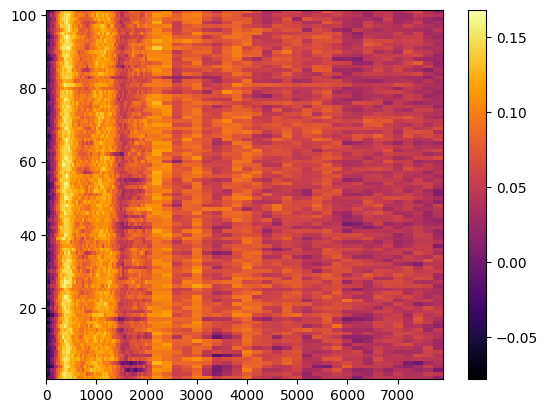

In [7]:
# December T2E
days = np.linspace(16,31,16)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-' + str(int(day)) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 80
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

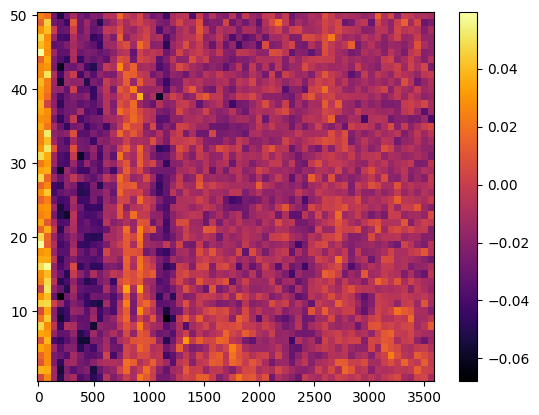

In [8]:
# December XY8
days = np.linspace(16,31,16)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-' + str(int(day)) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'XY8' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 0:
                datafile = mainFolder + dataFolder +'/XY8Object_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 60
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

In [ ]:
mainFolder = 'C:/Users/lukin2dmaterials/data/2023-03-06/'
for dataFolder in os.listdir(mainFolder):
    # print(dataFolder)
    if 'T2E' in dataFolder:
        idx = int(dataFolder[1:4])
        if idx > 3:
            datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
            sig, ref = dr.readData(datafile, type='T2E', typeNorm=1)

In [ ]:
mainFolder = 'C:/Users/lukin2dmaterials/data/2023-05-23/'
for dataFolder in os.listdir(mainFolder):
    # print(dataFolder)
    if 'T2E' in dataFolder:
        idx = int(dataFolder[1:4])
        if idx > 0 and idx < 100:
            datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
            guess = (0.15, 100, 1, 0)
            upperBounds = (np.inf, np.inf, 4, 0)
            sig, ref = dr.readData(datafile, type='T2E', typeNorm=1, 
                                   ifFit=1, guess=guess, upperBounds=upperBounds)

In [37]:
days = ["18"]
mainFolders = []
for day in days:
    mainFolders.append('C:/Users/lukin2dmaterials/data/2023-06-'+ day +"/")
t2arr = []; t2errarr = []; narr = []; nerrarr = []
for mainFolder in mainFolders:
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            
            if idx >= 1:
                ifFit = 1
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                guess = (0.15, 110, 4, -1)
                ntry = np.linspace(2, 4, 21); ctry = np.linspace(-0.02,0.04,7)
                perrs = np.zeros((len(ntry), len(ctry)))
                for i, nlow in enumerate(ntry):
                    for j, chigh in enumerate(ctry):
                        lowerBounds = (0,      0,      nlow, -1)    #(0,      0,      3.8,  -1)
                        upperBounds = (np.inf, np.inf, 4.01, chigh)  #(np.inf, np.inf, 4.01, -0.010)
                        sig, ref, popt, perr = dr.readData(datafile, type='T2E', typeNorm=1, endDataPoint=None, 
                                                        ifPlot=False, ifPrint=False,
                                            guess=guess, ifFit=ifFit, upperBounds=upperBounds, lowerBounds=lowerBounds)
                        perrs[i,j] = np.round(perr[1]/popt[1] + perr[2]/popt[2],3)
                        # perrs[i,j] = np.round(perr[1],3)
                # print(perrs)
                indices = np.unravel_index(np.argmin(perrs), perrs.shape)
                ngood = ntry[indices[0]]; cgood = ctry[indices[1]]
                print(ngood, cgood)

                lowerBounds = (0,      0,      ngood, -1)    #(0,      0,      3.8,  -1)
                upperBounds = (np.inf, np.inf, 4.01,  cgood)  #(np.inf, np.inf, 4.01, -0.010)
                sig, ref, popt, perr = dr.readData(datafile, type='T2E', typeNorm=1, endDataPoint=None, 
                                    ifPlot=False, ifPrint=False, startDataPoint=1,
                                    guess=guess, ifFit=ifFit, upperBounds=upperBounds, lowerBounds=lowerBounds)
                n = 50
                if len(sig) < n: 
                    print("Bad data: " + datafile)
                else:
                    t2arr.append(popt[1]); narr.append(popt[2]); t2errarr.append(perr[1]); nerrarr.append(perr[2])

t2arr = np.array(t2arr); t2errarr = np.array(t2errarr); narr = np.array(narr); nerrarr = np.array(nerrarr)
iters = np.arange(len(t2arr))

2.5 0.0
2.7 0.0
3.1 0.0
2.5 0.0
2.6 0.0
3.5 -0.02
2.4 0.0
2.7 0.0
4.0 0.04
Bad data: C:/Users/lukin2dmaterials/data/2023-06-18/#009_T2E_15-24-17/T2EObject_sig_set.dat
2.5 0.009999999999999998
2.0 0.009999999999999998
2.4 0.0


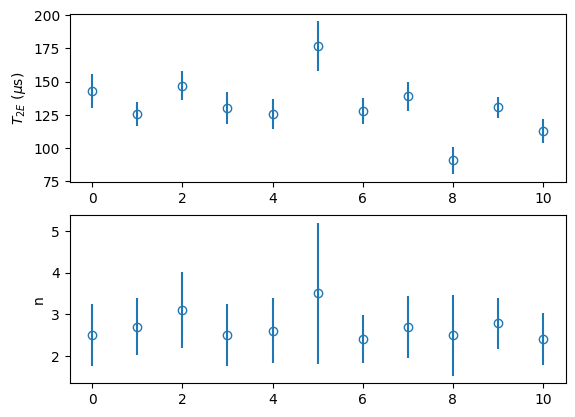

In [39]:
fig, axs = plt.subplots(2,1)
axs[0].errorbar(iters, t2arr,t2errarr, linestyle='', marker='o', markerfacecolor='none')
axs[0].set_ylabel("$T_{2E}$ ($\mu$s)")
# axs[0].axvline(x=4.5, ymin=0, ymax=1, color='red', linewidth=1)
# axs[0].axvline(x=9.5, ymin=0, ymax=1, color='red', linewidth=1)

axs[1].errorbar(iters, narr, nerrarr, linestyle='', marker='o', markerfacecolor='none')
# axs[1].axvline(x=4.5, ymin=0, ymax=1, color='red', linewidth=1)
# axs[1].axvline(x=9.5, ymin=0, ymax=1, color='red', linewidth=1)
axs[1].set_ylabel("n");

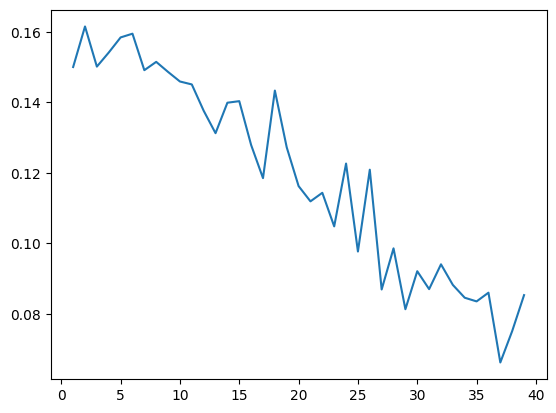

In [23]:
# Optimizing readout for pigtail 520
days = ["08","10", "11", "12"]
days = ["12"]
mainFolders = []
for day in days:
    mainFolders.append('C:/Users/lukin2dmaterials/data/2023-04-'+ day +"/")

NSmaxList = []
for mainFolder in mainFolders:
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                sig, ref = dr.readData(datafile, type='T2E', typeNorm=1, ifPlot=False)
                normedSig = (sig-ref)/(sig+ref)
                NSmax = np.max(normedSig)
                NSmaxList.append(NSmax)
NSmaxList = np.array(NSmaxList)
xPlot = range(len(NSmaxList))

fig,ax = plt.subplots()
ax.plot(xPlot,NSmaxList)

In [ ]:
mainFolder = 'C:/Users/lukin2dmaterials/data/2023-01-31/'
for dataFolder in os.listdir(mainFolder):
    # print(dataFolder)
    if 'XY8' in dataFolder:
        idx = int(dataFolder[1:4])
        if idx > 0:
            datafile = mainFolder + dataFolder +'/XY8Object_sig_set.dat'
            fig = dr.readData(datafile, type='XY8', typeNorm=1)

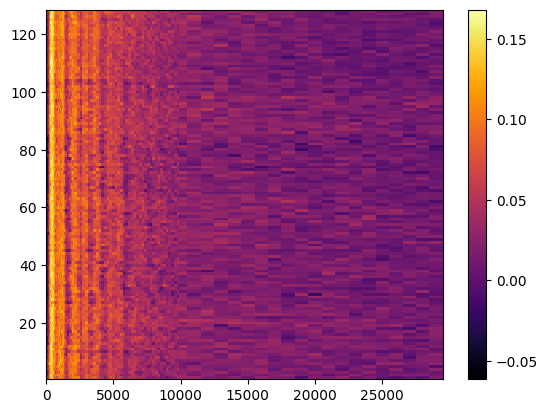

In [12]:
# January T2E
days = np.concatenate((np.linspace(1,13,13),np.linspace(29,31,3)))
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 110
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

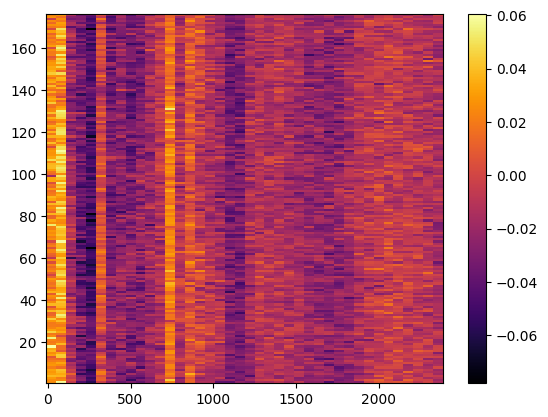

In [19]:
# February XY8
days = np.linspace(1,28,28)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-02-' + str(int(day)).zfill(2) + '/'
    if os.path.isdir(mainFolder):
        for dataFolder in os.listdir(mainFolder):
            # print(dataFolder)
            if 'XY8' in dataFolder:
                idx = int(dataFolder[1:4])
                if idx > 0:
                    datafile = mainFolder + dataFolder +'/XY8Object_sig_set.dat'
                    x_s, sig, ref = dr.readDataNoPlot(datafile)
                    sig = np.array(sig); ref = np.array(ref)
                    n = 40
                    if len(sig) < n: print(datafile)
                    x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                    contrast = (sig-ref)/(sig+ref)
                    dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

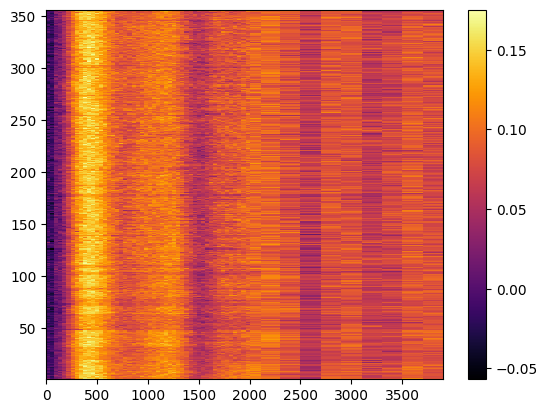

In [52]:
# February T2E
days = np.linspace(1,28,28)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-02-' + str(int(day)).zfill(2) + '/'
    if os.path.isdir(mainFolder):
        for dataFolder in os.listdir(mainFolder):
            # print(dataFolder)
            if 'T2E' in dataFolder:
                idx = int(dataFolder[1:4])
                if idx > 0:
                    datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                    x_s, sig, ref = dr.dataFolderreadDataNoPlot(datafile)
                    sig = np.array(sig); ref = np.array(ref)
                    n = 60
                    if len(sig) < n: print(datafile)
                    x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                    contrast = (sig-ref)/(sig+ref)
                    dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

Bad data: C:/Users/lukin2dmaterials/data/2023-05-10/#003_T2E_19-37-16/T2EObject_sig_set.dat
Bad data: C:/Users/lukin2dmaterials/data/2023-05-11/#036_T2E_17-12-17/T2EObject_sig_set.dat


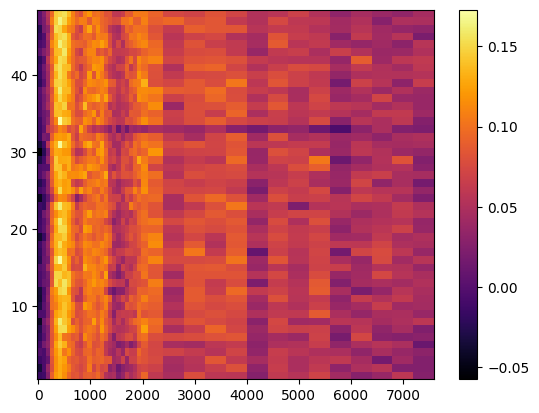

In [75]:
# May T2E
days = np.linspace(10,12,3)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-05-' + str(int(day)).zfill(2) + '/'
    if os.path.isdir(mainFolder):
        for dataFolder in os.listdir(mainFolder):
            # print(dataFolder)
            if 'T2E' in dataFolder:
                idx = int(dataFolder[1:4])
                if idx > 0:
                    datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                    x_s, sig, ref = dr.readDataNoPlot(datafile)
                    sig = np.array(sig); ref = np.array(ref)
                    n = 40
                    if len(sig) < n: 
                        print("Bad data: " + datafile)
                    else:
                        x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                        contrast = (sig-ref)/(sig+ref)
                        x_sPlot = x_s
                        dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_sPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

Bad data: C:/Users/lukin2dmaterials/data/2023-05-22/#044_T2E_11-08-11/T2EObject_sig_set.dat


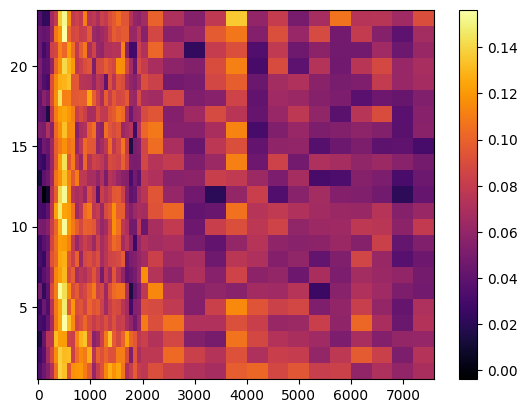

In [18]:
# May T2E
days = np.linspace(22,22,1)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-05-' + str(int(day)).zfill(2) + '/'
    if os.path.isdir(mainFolder):
        for dataFolder in os.listdir(mainFolder):
            # print(dataFolder)
            if 'T2E' in dataFolder:
                idx = int(dataFolder[1:4])
                if idx > 0:
                    datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                    x_s, sig, ref = dr.readDataNoPlot(datafile)
                    sig = np.array(sig); ref = np.array(ref)
                    n = 40
                    if len(sig) < n: 
                        print("Bad data: " + datafile)
                    else:
                        x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                        contrast = (sig-ref)/(sig+ref)
                        x_sPlot = x_s
                        dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_sPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')